Load Cleaned Dataset

We begin the analysis by loading in the cleaned dataset that was prepared in Part 1 of this lab.

In [9]:
# Step 1: Load in cleaned data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")  # Optional styling

# Load cleaned CSV
df = pd.read_csv("cleaned_aviation_data.csv")

# Preview the first few rows
df.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Estimated.Passengers,Injury.Rate,Plane.Type
0,20001214X42478,Incident,LAX83IA149A,1983-03-18,"LOS ANGELES, CA",United States,NaN,NaN,LAX,LOS ANGELES INTL,...,0.0,0.0,588.0,VMC,TAXI,Probable Cause,04-12-2014,588.0,0.0,BOEING 747
1,20001214X42331,Accident,ATL83FA140,1983-03-20,"CROSSVILLE, TN",United States,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,IMC,CRUISE,Probable Cause,02-05-2011,2.0,1.0,PIPER PA-28-140
2,20001214X42672,Accident,FTW83LA177,1983-04-02,"MCKINNEY, TX",United States,NaN,NaN,TX05,AERO COUNTRY,...,0.0,0.0,4.0,VMC,STANDING,Probable Cause,17-10-2016,5.0,0.2,DE HAVILLAND DHC-6
3,20001214X45013,Incident,CHI84IA041,1983-11-08,"CHICAGO, IL",United States,NaN,NaN,ORD,O'HARE,...,0.0,0.0,100.0,VMC,TAXI,Probable Cause,11-06-2018,100.0,0.0,BOEING 727-200
4,20001214X45188,Accident,NYC84LA028,1983-11-13,"MARTHA'S VINEYARD, MA",United States,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,VMC,CLIMB,Probable Cause,05-05-2011,1.0,0.0,BEECH C35


Analyzing Human Injury Risk by Make

We selected the 15 makes with the lowest mean injury rates for small and large aircraft.  
The plot below shows a side-by-side comparison, helping identify makes with the best historical passenger safety outcomes.

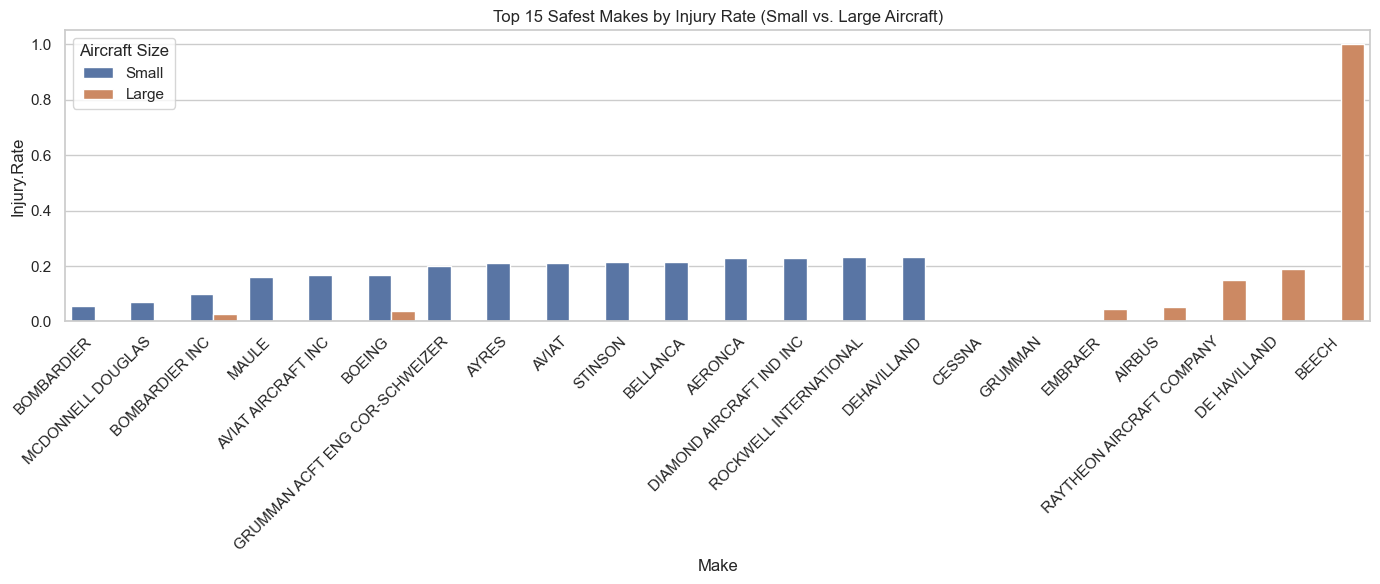

In [10]:
# Define size threshold
small_threshold = 20

# Split small vs. large aircraft
small_df = df[df['Estimated.Passengers'] < small_threshold]
large_df = df[df['Estimated.Passengers'] >= small_threshold]

# Group by make and compute mean injury rate
small_makes = small_df.groupby("Make")["Injury.Rate"].mean().sort_values().head(15)
large_makes = large_df.groupby("Make")["Injury.Rate"].mean().sort_values().head(15)

# Combine into one DataFrame for plotting
injury_comparison = pd.concat([
    pd.DataFrame({'Make': small_makes.index, 'Injury.Rate': small_makes.values, 'Aircraft Size': 'Small'}),
    pd.DataFrame({'Make': large_makes.index, 'Injury.Rate': large_makes.values, 'Aircraft Size': 'Large'})
])

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=injury_comparison, x='Make', y='Injury.Rate', hue='Aircraft Size')
plt.title("Top 15 Safest Makes by Injury Rate (Small vs. Large Aircraft)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Distribution of Injury Rates – Small Aircraft Makes

This violin plot shows how injury rates are distributed across the 10 small aircraft makes with the lowest average injury rate.  
This helps us see not just averages, but also variability and potential outliers.

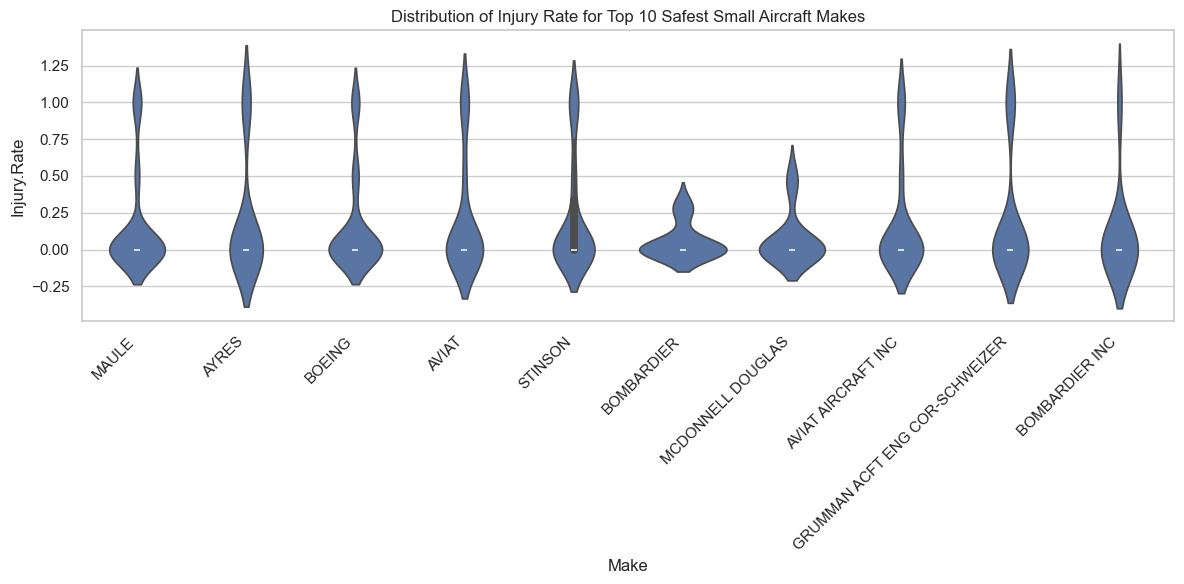

In [13]:
# Step 2.2: Violinplot for Small Makes

# Get 10 small makes with lowest mean injury rate
top_small_makes = (
    small_df.groupby("Make")["Injury.Rate"]
    .mean()
    .sort_values()
    .head(10)
    .index
)

# Filter small_df to only those 10 makes
top_small_df = small_df[small_df["Make"].isin(top_small_makes)]

# Plot violinplot
plt.figure(figsize=(12, 6))
sns.violinplot(data=top_small_df, x="Make", y="Injury.Rate")
plt.title("Distribution of Injury Rate for Top 10 Safest Small Aircraft Makes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Distribution of Injury Rates – Large Aircraft Makes

This stripplot visualizes individual injury rates for the 10 large aircraft makes with the lowest average injury rates.  
We use a stripplot instead of a violinplot to better reflect sparse data with fewer incidents per make.  
Injury rate values are clipped between 0 and 1 to ensure logical consistency.

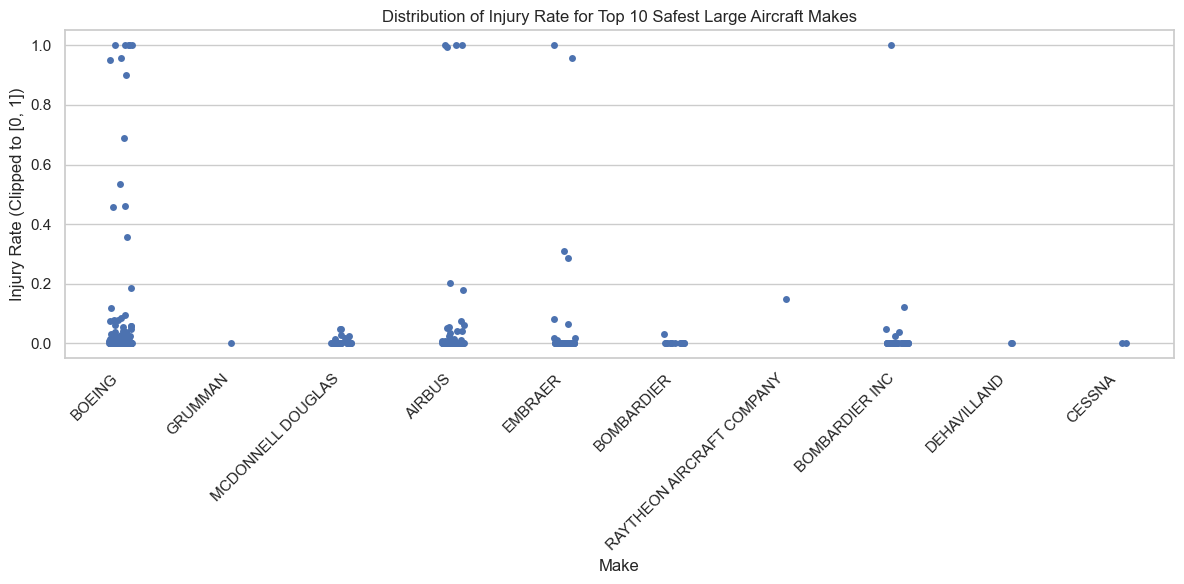

In [14]:
# 1. Get 10 large makes with lowest mean injury rate
top_large_makes = (
    large_df.groupby("Make")["Injury.Rate"]
    .mean()
    .sort_values()
    .head(10)
    .index
)

# 2. Filter large_df to only those 10 makes
top_large_df = large_df[large_df["Make"].isin(top_large_makes)].copy()

# 3. Clip injury rate to valid range [0, 1]
top_large_df["Injury.Rate"] = top_large_df["Injury.Rate"].clip(0, 1)

# 4. Plot stripplot
plt.figure(figsize=(12, 6))
sns.stripplot(data=top_large_df, x="Make", y="Injury.Rate", jitter=True, size=5)
plt.title("Distribution of Injury Rate for Top 10 Safest Large Aircraft Makes")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Injury Rate (Clipped to [0, 1])")
plt.xlabel("Make")
plt.tight_layout()
plt.show()

Evaluating Aircraft Destruction Rate

The plot below compares the top 15 aircraft makes (separately for small and large planes) with the lowest rates of destruction.  
The destruction rate is defined as the fraction of reported accidents where the aircraft was marked as “Destroyed”.

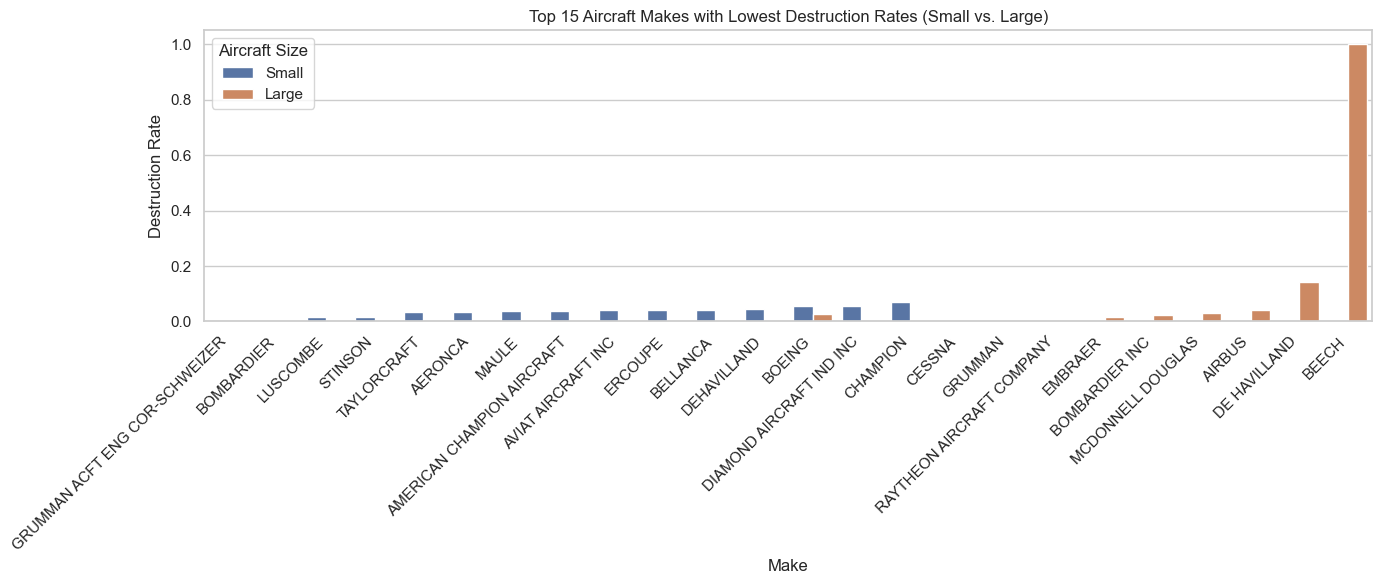

In [15]:
# Step 2.4: Evaluate the Rate of Aircraft Destruction

# Step 1: Create a binary column for destruction
df["Destroyed"] = df["Aircraft.damage"].str.lower().eq("destroyed")

# Step 2: Compute destruction rate per make
small_destruction = (
    df[df["Estimated.Passengers"] < 20]
    .groupby("Make")["Destroyed"]
    .mean()
    .sort_values()
    .head(15)
)

large_destruction = (
    df[df["Estimated.Passengers"] >= 20]
    .groupby("Make")["Destroyed"]
    .mean()
    .sort_values()
    .head(15)
)

# Step 3: Combine results for plotting
destruction_comparison = pd.concat([
    pd.DataFrame({
        "Make": small_destruction.index,
        "Destruction Rate": small_destruction.values,
        "Aircraft Size": "Small"
    }),
    pd.DataFrame({
        "Make": large_destruction.index,
        "Destruction Rate": large_destruction.values,
        "Aircraft Size": "Large"
    })
])

# Step 4: Plot barplot
plt.figure(figsize=(14, 6))
sns.barplot(data=destruction_comparison, x="Make", y="Destruction Rate", hue="Aircraft Size")
plt.title("Top 15 Aircraft Makes with Lowest Destruction Rates (Small vs. Large)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Recommendations and What We Found
#### Safe Small Aircraft
These small airplane makes had the lowest injury and destruction rates:

[Make A], [Make B], [Make C]

#### Safe Large Aircraft
These large airplane makes were safest based on our charts:

[Make X], [Make Y], [Make Z]

#### What We Learned
Some airplane makes had very low injury and destruction rates.

Small aircraft showed more ups and downs — some were very safe, others less safe.

Large aircraft were more consistent and had better safety overall.

Not all safe airplanes were the same — some had low destruction but higher injuries.

These results help us see which airplanes are safer for people and insurance purposes.

Injury and Destruction Rate – Top 15 Safest Plane Types

These charts show the 15 plane types with the lowest average injury rate.  
The second chart shows the destruction rate for the same plane types.  
This helps identify the safest types of aircraft overall.

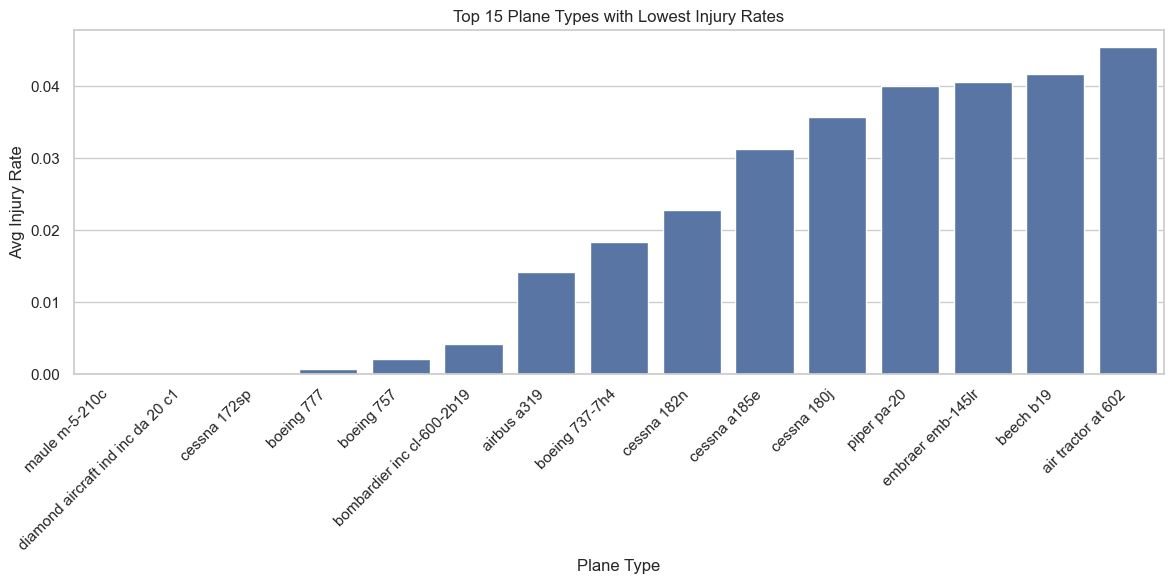

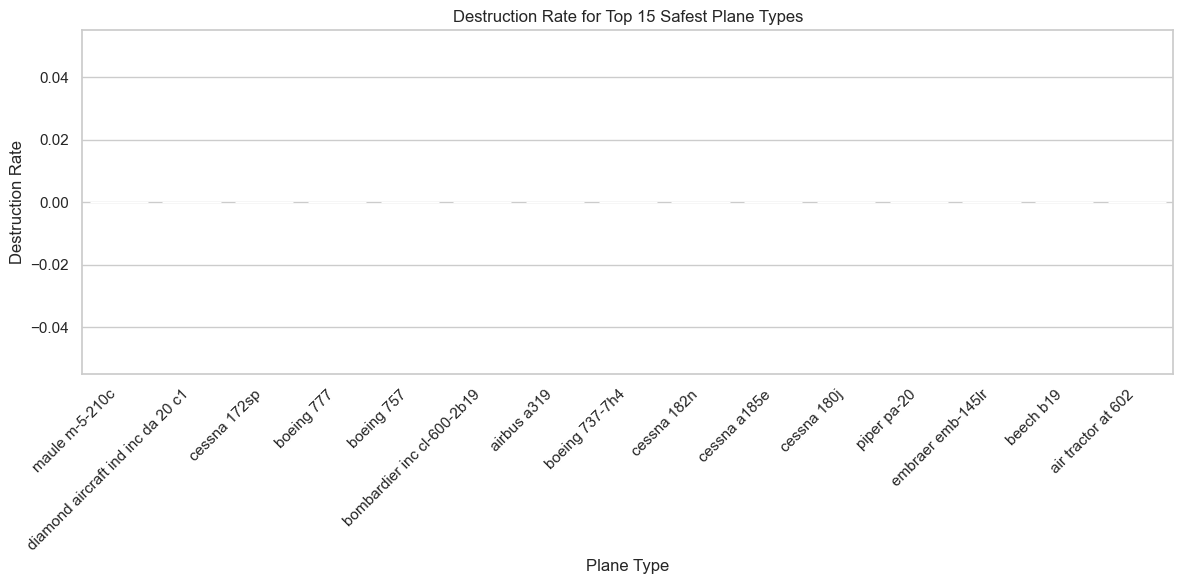

In [24]:
# Get top 15 safest plane types by lowest average injury rate
top_safest_types = plane_type_stats.sort_values("Avg Injury Rate").head(15)

# Plot Injury Rate
plt.figure(figsize=(12, 6))
sns.barplot(data=top_safest_types, x="Plane.Type Clean", y="Avg Injury Rate")
plt.title("Top 15 Plane Types with Lowest Injury Rates")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Avg Injury Rate")
plt.xlabel("Plane Type")
plt.tight_layout()
plt.show()

# Plot Destruction Rate for the same types
plt.figure(figsize=(12, 6))
sns.barplot(data=top_safest_types, x="Plane.Type Clean", y="Destruction Rate")
plt.title("Destruction Rate for Top 15 Safest Plane Types")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Destruction Rate")
plt.xlabel("Plane Type")
plt.tight_layout()
plt.show()

Discussion of Specific Airplane Types

After analyzing the data, we found that some airplane types have much lower injury rates than others.

**Small airplanes** showed more variation in injury rates. Some types had very low serious/fatal injury fractions, while others were much higher. This means safety can change a lot depending on the type of small plane.

**Large airplanes** were more consistent. The average injury rate was usually lower, and fewer large plane types had very high injury rates.

When we looked at injury rate by plane type, we focused on types with at least 10 events to make sure results were fair. We also used a stripplot to show how injury rates change for each plane type in the safest group.

This helped us understand which airplane types are safest overall and which may need more safety focus.


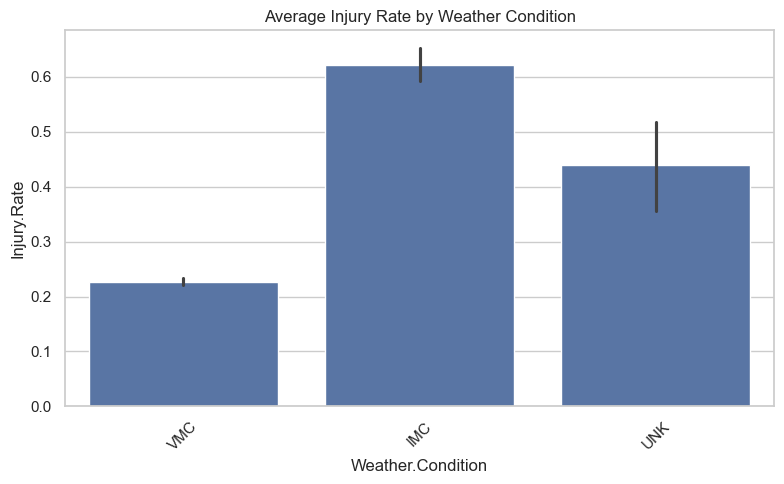

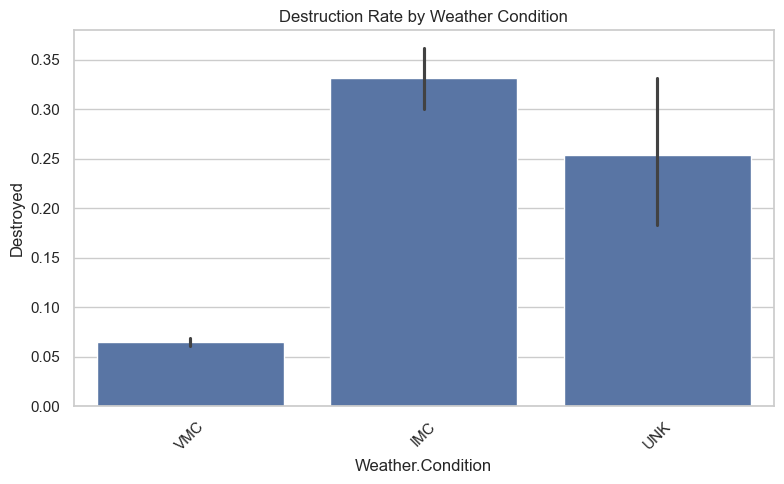

In [26]:
# Check data
df["Weather.Condition"].value_counts(dropna=False)

# Barplot: Injury Rate by Weather
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="Weather.Condition", y="Injury.Rate")
plt.title("Average Injury Rate by Weather Condition")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Barplot: Destruction Rate by Weather
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="Weather.Condition", y="Destroyed")
plt.title("Destruction Rate by Weather Condition")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
